# Assignment 1 
# (Author: Jan Klinkosz, id number: 394 342, kaggle nick: Johny7013)

First of all we need to import python modules that are necessary to run

In [144]:
import xgboost as xgb
import pandas as pd
import datetime
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, auc
import matplotlib.pyplot as plt
import graphviz

Download data

In [145]:
raw_data1 = pd.read_csv('bank-classification.csv')
raw_data2 = pd.read_csv('bank-classification.csv')

Global data

In [146]:
year = 2012
base_date = "2011-01-01"
num_round = 150
acceptable_score = 0.796
good_models = []

# Solution number 1

Feature engineering

In [147]:
data = raw_data1

# change birth_date to age
data['birth_date'] = data['birth_date'].apply(lambda date: year - int(date[0:4]))
data = data.rename(columns={'birth_date': 'age'})

# change contact date to weeks since last contact
data['contact_date'] = data['contact_date'].apply(
    lambda date: (datetime.datetime.strptime(base_date, "%Y-%m-%d")
                  - datetime.datetime.strptime(date, "%Y-%m-%d")).days // 7)
data = data.rename(columns={'contact_date': 'weeks_since_last_contact'})

# drop id column
data = data.drop(columns="id")

# add new feature, weeks since last contact divided by number of contact in this campaign
# they are both important features according to previous reasearch so try then together
new_feature = data['weeks_since_last_contact'].values / data['campaign'].values
data = pd.concat([data, pd.Series(new_feature).rename("weeks/campaign")], axis=1)

# transform cathegorical features to one hot encoding
for column in data:
    if data[column].dtype == object and column != 'y':
        data[column] = pd.Categorical(data[column])
        dfDummies = pd.get_dummies(data[column], prefix=column + '_category')
        data = data.drop(columns=column)
        data = pd.concat([data, dfDummies], axis=1)
        
# function to change classes of feature to consecutive natural numbers
# e.g. for marital: singiel - 0, married - 1, divorced - 2 etc.
def label_encode(feature):
    encoder = preprocessing.LabelEncoder()
    encoder = encoder.fit(feature)
    return encoder.transform(feature)


Function to cross validation

In [148]:
def k_fold(number_of_splits, X, y, num_round, param):
    kf = KFold(n_splits=number_of_splits, random_state=89423, shuffle=True)
    
    #scores = []

    X_values = X.values
    y_values = y

    for train_index, test_index in kf.split(X_values, y_values):
        X_train, X_test = X_values[train_index], X_values[test_index]
        y_train, y_test = y_values[train_index], y_values[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        evallist = [(dtrain, 'train'), (dtest, 'eval')]

        model = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=40)

        # main purpose of this function is to get acceptable models (good_models)
        # it's models with higher score than acceptable_score on y_test
        if model.best_score > acceptable_score:
            good_models.append(model)

        preds = model.predict(dtest, ntree_limit=model.best_ntree_limit)

        #scores.append(roc_auc_score(y_test, preds))

    # It's possible to see scores of consecutive models and mean score when 
    # print(scores)
    #return np.mean(scores)

Prepare the data for training and genarating a result

In [149]:
# data with known y
training_data = data.query('y != "unknown"')

# data with unknown y
to_predict = data.query('y == "unknown"')

# remove y from data to predict
to_predict = to_predict.drop(columns="y")

y = training_data['y']
# remove results from data passed to trening
X = training_data.drop(columns="y")

# change yes and no to 1 and 0
y = label_encode(y)

Split the data

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

Params for training in k_fold and king_model (explanation in further part)

In [151]:
param_k_fold = {
    'max_depth': 2, 
    'eta': 0.3, 
    'objective': 'binary:logistic', 
    'nthread': 4, 
    'eval_metric': 'auc',
    'num_parallel_tree': 10, 
    'verbosity_eval': False, 
    'subsample': 0.8
}

param_king_model = {
    'max_depth': 2, 
    'eta': 1, 
    'objective': 'binary:logistic', 
    'nthread': 4, 
    'eval_metric': 'auc',
    'num_parallel_tree': 10, 
    'verbosity_eval': False, 
    'subsample': 1
}

Train models

In [152]:
# get good_models
k_fold(10, X_train, y_train, num_round, param_k_fold)

# train king_model (i.e. model trained on all data with the higer importance to result)
dtrain = xgb.DMatrix(X.values, label=y)
evallist = [(dtrain, 'train')]
king_model = xgb.train(param_king_model, dtrain, num_round, evallist)

[0]	train-auc:0.759221	eval-auc:0.760124
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 40 rounds.
[1]	train-auc:0.762656	eval-auc:0.762738
[2]	train-auc:0.762659	eval-auc:0.762743
[3]	train-auc:0.76481	eval-auc:0.764229
[4]	train-auc:0.769688	eval-auc:0.772339
[5]	train-auc:0.781073	eval-auc:0.781779
[6]	train-auc:0.782802	eval-auc:0.780959
[7]	train-auc:0.785012	eval-auc:0.784198
[8]	train-auc:0.786222	eval-auc:0.784214
[9]	train-auc:0.788049	eval-auc:0.784362
[10]	train-auc:0.789164	eval-auc:0.786033
[11]	train-auc:0.789961	eval-auc:0.786174
[12]	train-auc:0.790193	eval-auc:0.785782
[13]	train-auc:0.790977	eval-auc:0.785661
[14]	train-auc:0.791646	eval-auc:0.784933
[15]	train-auc:0.79175	eval-auc:0.785167
[16]	train-auc:0.791898	eval-auc:0.785582
[17]	train-auc:0.79226	eval-auc:0.785378
[18]	train-auc:0.793831	eval-auc:0.785465
[19]	train-auc:0.794127	eval-auc:0.785601
[20]	train-auc:0.794857	eval-auc

[67]	train-auc:0.807811	eval-auc:0.793076
[68]	train-auc:0.807967	eval-auc:0.79288
[69]	train-auc:0.808187	eval-auc:0.793017
[70]	train-auc:0.808361	eval-auc:0.792893
[71]	train-auc:0.808619	eval-auc:0.792863
[72]	train-auc:0.808764	eval-auc:0.793046
[73]	train-auc:0.808998	eval-auc:0.793054
[74]	train-auc:0.809255	eval-auc:0.793084
[75]	train-auc:0.809417	eval-auc:0.792984
[76]	train-auc:0.809657	eval-auc:0.793014
[77]	train-auc:0.80987	eval-auc:0.792678
[78]	train-auc:0.810002	eval-auc:0.792697
[79]	train-auc:0.810099	eval-auc:0.792842
[80]	train-auc:0.810337	eval-auc:0.792866
[81]	train-auc:0.810487	eval-auc:0.792931
[82]	train-auc:0.81068	eval-auc:0.792922
[83]	train-auc:0.810832	eval-auc:0.793388
Stopping. Best iteration:
[43]	train-auc:0.801246	eval-auc:0.794281

[0]	train-auc:0.758186	eval-auc:0.770548
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 40 rounds.
[1]	train-auc:0.760064	eval-auc:0.7716

[41]	train-auc:0.802828	eval-auc:0.781051
[42]	train-auc:0.803055	eval-auc:0.781097
[43]	train-auc:0.803276	eval-auc:0.780828
[44]	train-auc:0.80351	eval-auc:0.781008
[45]	train-auc:0.803738	eval-auc:0.781325
[46]	train-auc:0.803889	eval-auc:0.781233
[47]	train-auc:0.804317	eval-auc:0.781523
[48]	train-auc:0.804563	eval-auc:0.781571
[49]	train-auc:0.804885	eval-auc:0.781763
[50]	train-auc:0.804969	eval-auc:0.781649
[51]	train-auc:0.805311	eval-auc:0.781912
[52]	train-auc:0.805506	eval-auc:0.781722
[53]	train-auc:0.805885	eval-auc:0.781643
[54]	train-auc:0.806106	eval-auc:0.781508
[55]	train-auc:0.806442	eval-auc:0.781555
[56]	train-auc:0.806547	eval-auc:0.781558
[57]	train-auc:0.806766	eval-auc:0.781601
[58]	train-auc:0.806904	eval-auc:0.78156
[59]	train-auc:0.807256	eval-auc:0.781617
[60]	train-auc:0.807663	eval-auc:0.781626
[61]	train-auc:0.807922	eval-auc:0.78161
[62]	train-auc:0.808193	eval-auc:0.781702
[63]	train-auc:0.808335	eval-auc:0.78161
[64]	train-auc:0.808518	eval-auc:0.781

[23]	train-auc:0.795595	eval-auc:0.796184
[24]	train-auc:0.79602	eval-auc:0.796526
[25]	train-auc:0.796264	eval-auc:0.796278
[26]	train-auc:0.796399	eval-auc:0.796093
[27]	train-auc:0.796715	eval-auc:0.796069
[28]	train-auc:0.796974	eval-auc:0.795502
[29]	train-auc:0.797319	eval-auc:0.795741
[30]	train-auc:0.797689	eval-auc:0.795588
[31]	train-auc:0.79801	eval-auc:0.796044
[32]	train-auc:0.798237	eval-auc:0.796255
[33]	train-auc:0.798683	eval-auc:0.796688
[34]	train-auc:0.798878	eval-auc:0.796767
[35]	train-auc:0.799094	eval-auc:0.796816
[36]	train-auc:0.799324	eval-auc:0.796791
[37]	train-auc:0.799669	eval-auc:0.796519
[38]	train-auc:0.799983	eval-auc:0.796533
[39]	train-auc:0.800487	eval-auc:0.797119
[40]	train-auc:0.800761	eval-auc:0.796908
[41]	train-auc:0.800947	eval-auc:0.79714
[42]	train-auc:0.801242	eval-auc:0.797283
[43]	train-auc:0.801552	eval-auc:0.797066
[44]	train-auc:0.801683	eval-auc:0.797179
[45]	train-auc:0.802131	eval-auc:0.79748
[46]	train-auc:0.802377	eval-auc:0.797

[54]	train-auc:0.80421	eval-auc:0.791068
[55]	train-auc:0.804474	eval-auc:0.791148
[56]	train-auc:0.804812	eval-auc:0.791516
[57]	train-auc:0.80498	eval-auc:0.791315
[58]	train-auc:0.805141	eval-auc:0.791686
[59]	train-auc:0.80543	eval-auc:0.792235
[60]	train-auc:0.80569	eval-auc:0.792473
[61]	train-auc:0.805789	eval-auc:0.792416
[62]	train-auc:0.806007	eval-auc:0.792382
[63]	train-auc:0.806312	eval-auc:0.792501
[64]	train-auc:0.806668	eval-auc:0.791932
[65]	train-auc:0.806823	eval-auc:0.791878
[66]	train-auc:0.807052	eval-auc:0.791856
[67]	train-auc:0.807291	eval-auc:0.791581
[68]	train-auc:0.807626	eval-auc:0.791929
[69]	train-auc:0.807772	eval-auc:0.791884
[70]	train-auc:0.808007	eval-auc:0.792034
[71]	train-auc:0.80835	eval-auc:0.791808
[72]	train-auc:0.808498	eval-auc:0.792079
[73]	train-auc:0.80871	eval-auc:0.792306
[74]	train-auc:0.808927	eval-auc:0.79219
[75]	train-auc:0.809176	eval-auc:0.792504
[76]	train-auc:0.809418	eval-auc:0.79249
[77]	train-auc:0.809624	eval-auc:0.792453


Genrate predictions (compute weighted average of all good models predictions with weights equal to 1 and king model predictions weight equal to 3)

In [153]:
dtest = xgb.DMatrix(to_predict.values)

preds_sum = np.zeros(len(to_predict))
for model in good_models:
    preds = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    preds_sum += preds

king_preds = king_model.predict(dtest)
preds_sum += 3 * king_preds

preds = preds_sum / (len(good_models) + 3)

Generate csv file with predictions to records with y value equal to unknown

In [154]:
# path to directory where predictions shall be placed
result_name = "jk394342_predictions_solution1.csv"

df = pd.DataFrame(None, columns=['id', 'y'])

df['id'] = raw_data.query('y=="unknown"')['id']
df['y'] = preds

df.to_csv(result_name, index=False)

Visualization of feature importance in different models

good_model_0


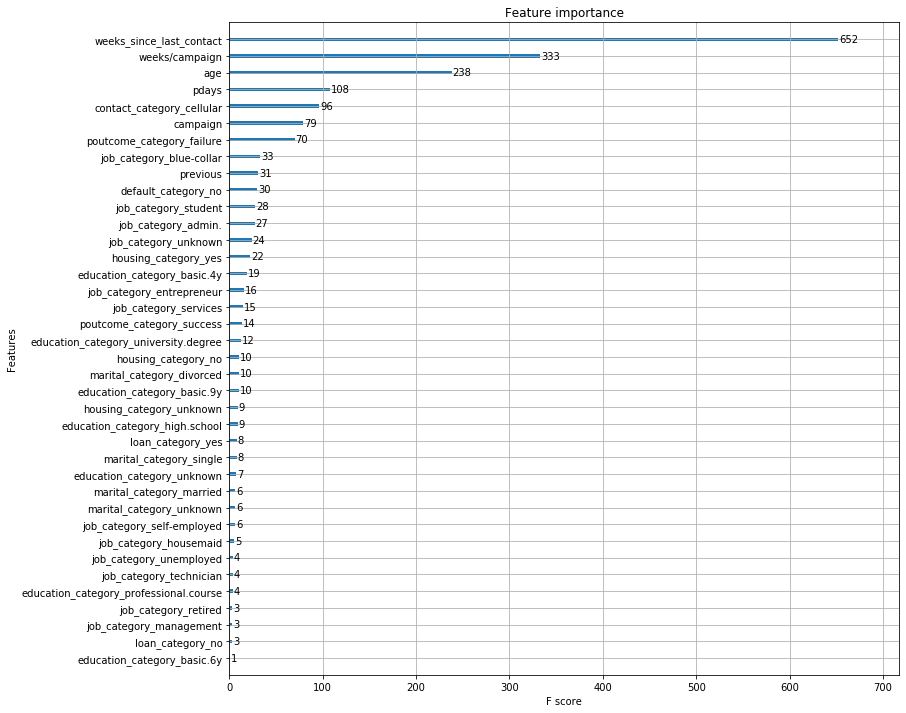

good_model_1


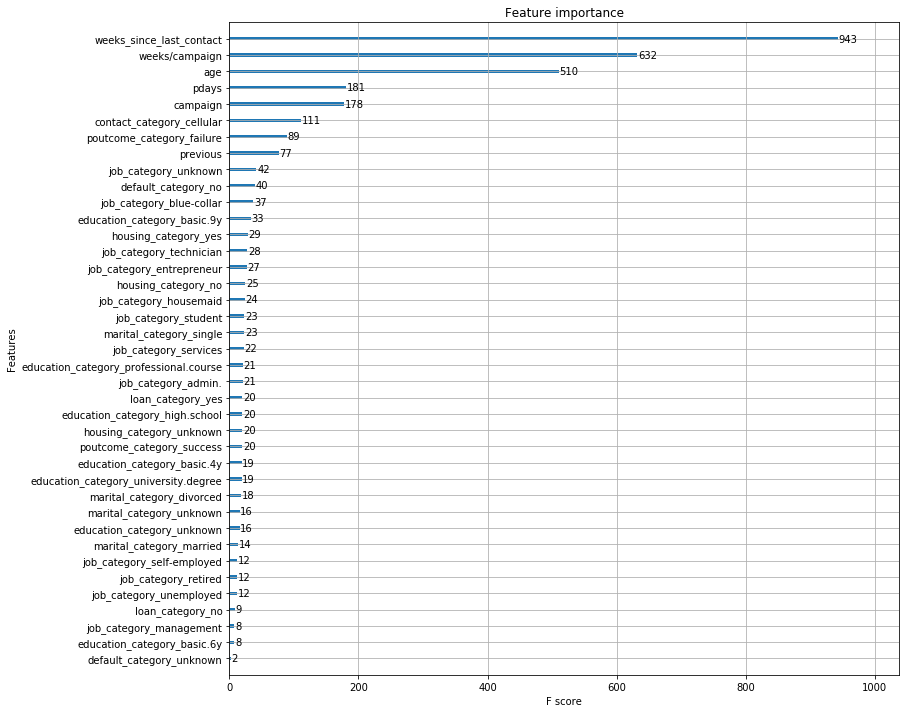

good_model_2


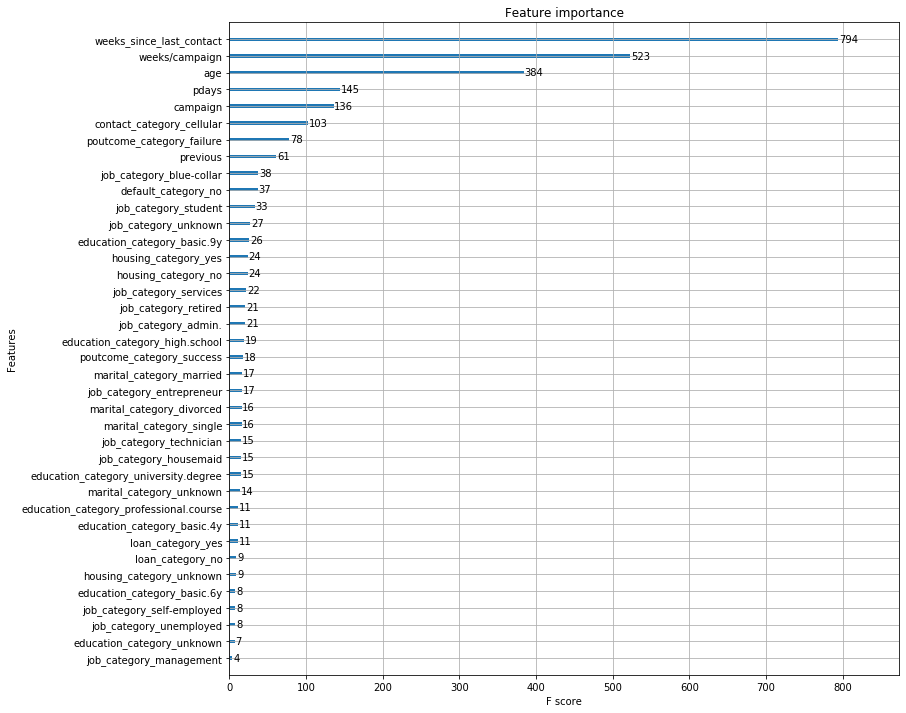

good_model_3


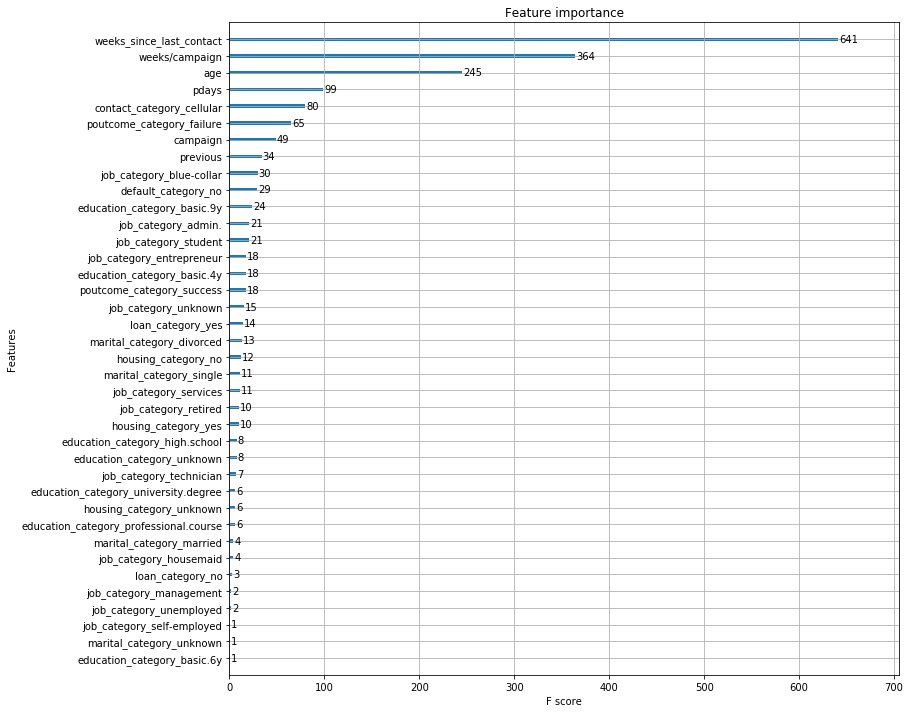

good_model_4


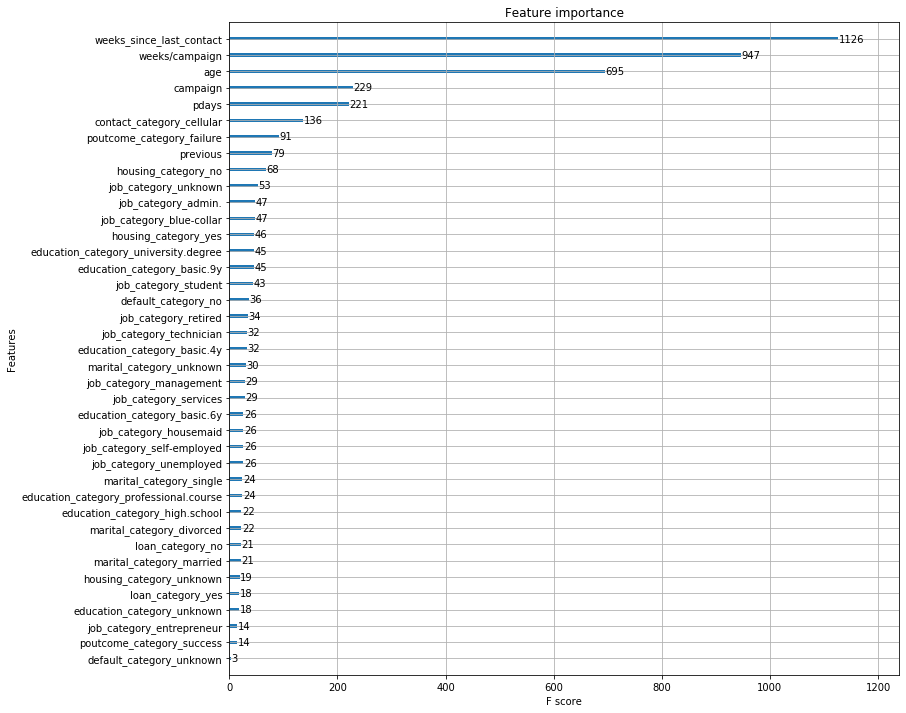

king_model


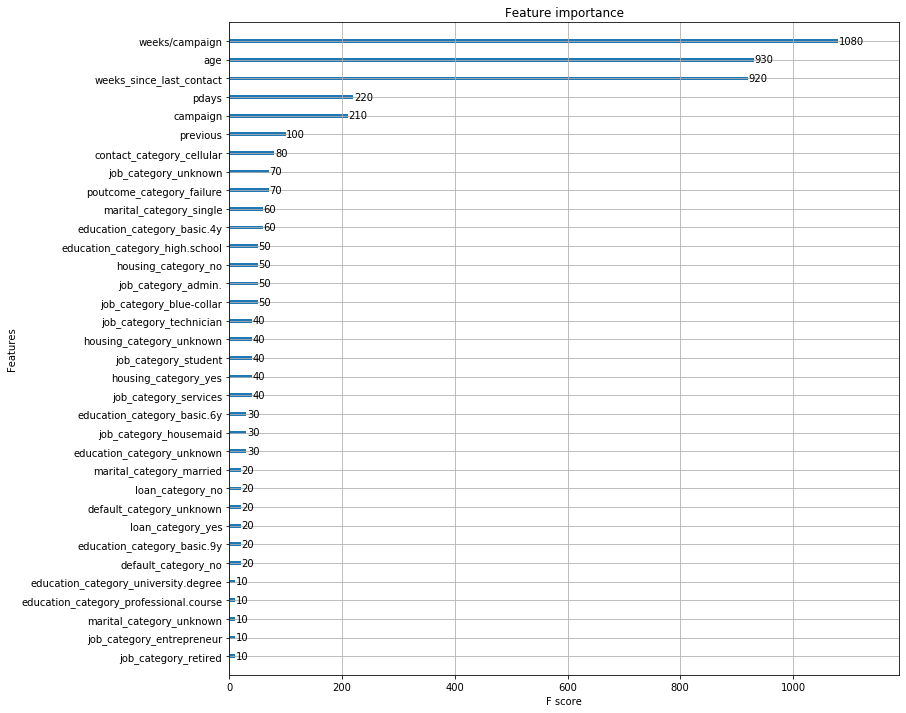

In [155]:
%matplotlib inline
plt.rcParams['figure.figsize']= [12, 12]

i = 0
for model in good_models:
    print("good_model_" + str(i))
    # go back to true features names
    mapper = {'f{0}'.format(i): v for i, v in enumerate(X)}
    mapped = {mapper[k]: v for k, v in model.get_fscore().items()}
    xgb.plot_importance(mapped)
    plt.show()
    i = i + 1

print("king_model")
mapper = {'f{0}'.format(i): v for i, v in enumerate(X)}
mapped = {mapper[k]: v for k, v in king_model.get_fscore().items()}
xgb.plot_importance(mapped)
plt.show()


# Solution number 2

Feature engineering

In [156]:
data = raw_data2

# change birth_date to age
data['birth_date'] = data['birth_date'].apply(lambda date: year - int(date[0:4]))
data = data.rename(columns={'birth_date': 'age'})

# change contact date to months since last contact
data['contact_date'] = data['contact_date'].apply(
    lambda date: (datetime.datetime.strptime(base_date, "%Y-%m-%d")
                  - datetime.datetime.strptime(date, "%Y-%m-%d")).days // 30)
data = data.rename(columns={'contact_date': 'months_since_last_contact'})

# function to change classes of feature to consecutive natural numbers
# e.g. for marital: singiel - 0, married - 1, divorced - 2 etc.
def label_encode(feature):
    encoder = preprocessing.LabelEncoder()
    encoder = encoder.fit(feature)
    return encoder.transform(feature)

def label_encode_object_columns_in_dataframe(df):
    for column in df:
        if df[column].dtype == object:
            df[column] = label_encode(df[column])
    return df

Prepare the data for training and genarating a result

In [157]:
training_data = data.query('y != "unknown"')
to_predict = data.query('y == "unknown"')

# remove y form data to predict
to_predict = to_predict.drop(columns=["y"])

y = training_data['y']
# remove results from data passed to trening
X = training_data.drop(columns="y")

y = label_encode(y)

X = label_encode_object_columns_in_dataframe(X)

Previous experiments on this parameters where quite promising, so I decided to train model on all data and take result form kaggle as test.

In [158]:
param = {
    'max_depth': 2, 
    'eta': 0.3, 
    'objective': 'binary:logistic', 
    'nthread': 4, 
    'eval_metric': 'auc',
    'num_parallel_tree': 150, 
    'verbosity_eval': 0, 
    'subsample': 0.8
}
dtrain = xgb.DMatrix(X, label=y)
evallist = [(dtrain, 'train')]
model = xgb.train(param, dtrain, num_round, evallist)

[0]	train-auc:0.761227
[1]	train-auc:0.766238
[2]	train-auc:0.767336
[3]	train-auc:0.767858
[4]	train-auc:0.782738
[5]	train-auc:0.783575
[6]	train-auc:0.783789
[7]	train-auc:0.788174
[8]	train-auc:0.788319
[9]	train-auc:0.791992
[10]	train-auc:0.792568
[11]	train-auc:0.793844
[12]	train-auc:0.794245
[13]	train-auc:0.7943
[14]	train-auc:0.794465
[15]	train-auc:0.795032
[16]	train-auc:0.79535
[17]	train-auc:0.79589
[18]	train-auc:0.796463
[19]	train-auc:0.79702
[20]	train-auc:0.797501
[21]	train-auc:0.798069
[22]	train-auc:0.798467
[23]	train-auc:0.79895
[24]	train-auc:0.799211
[25]	train-auc:0.799691
[26]	train-auc:0.800152
[27]	train-auc:0.800486
[28]	train-auc:0.800836
[29]	train-auc:0.801264
[30]	train-auc:0.80157
[31]	train-auc:0.801854
[32]	train-auc:0.802197
[33]	train-auc:0.802594
[34]	train-auc:0.802985
[35]	train-auc:0.80353
[36]	train-auc:0.803899
[37]	train-auc:0.804395
[38]	train-auc:0.804751
[39]	train-auc:0.805135
[40]	train-auc:0.80548
[41]	train-auc:0.805902
[42]	train-

Generate predictions

In [159]:
to_predict = label_encode_object_columns_in_dataframe(to_predict)

dtest = xgb.DMatrix(to_predict)
ypred = model.predict(dtest)

Generate csv file with predictions to records with y value equal to unknown

In [160]:
# path to directory where predictions shall be placed
result_name = "jk394342_predictions_solution2.csv"

df = pd.DataFrame(None, columns=['id', 'y'])

df['id'] = raw_data.query('y=="unknown"')['id']
df['y'] = ypred

df.to_csv(result_name, index=False)

Visualization of feature importance in model

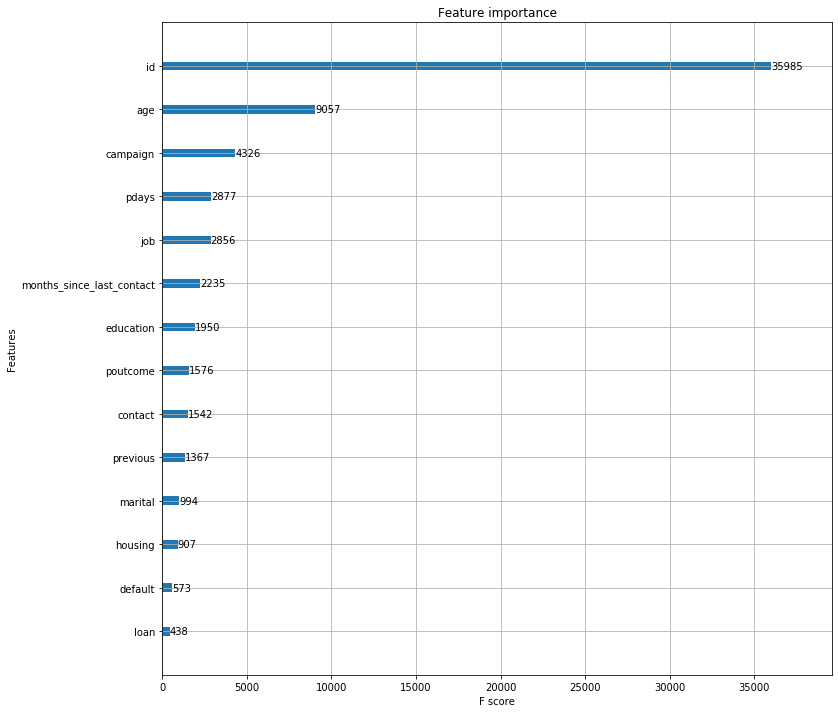

In [161]:
%matplotlib inline
plt.rcParams['figure.figsize']= [12, 12]

xgb.plot_importance(model)
plt.show()


Id as the most important feature and this approach gives great results. That was huge surprise to me. Is everything OK with this dataset at all?